# Dynamic damages: state variable (z,y)

In [174]:
import numpy as np
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from utilities import dLambda
from supportfunctions import finiteDiff
import matplotlib.pyplot as plt
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d

In [20]:
solu = pickle.load(open('../data/solution/solu_dynamicdmg_51*101_0305_16:39', 'rb'))

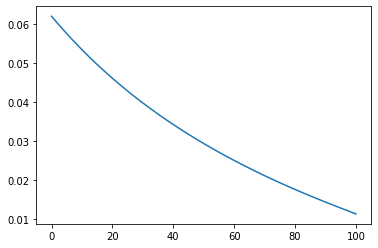

In [169]:
plt.plot(solu['solu_dynamicdmg'][0]['phi'][25])

In [36]:
solu['y_grid'][20]
numy_bar = solu['numy_bar']
numy_bar

20

In [46]:
y = solu['y_grid'][:numy_bar+1]
y.shape

(21,)

In [38]:
# backward induction
rho = .9
mu2 = 1.86/1000
sigma2 = solu['sigma2']

In [39]:
solu_dict = solu['solu_dynamicdmg']
z_grid = solu['z_grid']
y_grid = solu['y_grid']
hz = solu['hz']
hy = solu['hy']
delta = .01
eta = .032
v_n = solu['v_n']

In [42]:
gamma2pList = np.array([0, 2*0.0197])
v0 = solu_dict[gamma2pList[0]]['phi'][:, :numy_bar+1]
v1 = solu_dict[gamma2pList[1]]['phi'][:, :numy_bar+1]

In [47]:
v0.shape, v1.shape

((51, 21), (51, 21))

In [49]:
numdmg = 2
dmg_weights = [.5, .5]
terminal_condition = np.average([v0, v1], axis=0, weights=dmg_weights)

In [209]:
terminal_condition[:,-1]

array([0.03350136, 0.03346828, 0.03343831, 0.03341076, 0.03338511,
       0.033361  , 0.03333818, 0.03331646, 0.0332957 , 0.03327578,
       0.03325661, 0.03323812, 0.03322024, 0.03320292, 0.03318611,
       0.03316978, 0.03315388, 0.03313839, 0.03312328, 0.03310853,
       0.03309411, 0.03308001, 0.03306622, 0.0330527 , 0.03303946,
       0.03302648, 0.03301375, 0.03300126, 0.03298898, 0.03297692,
       0.03296506, 0.03295338, 0.03294189, 0.03293058, 0.03291943,
       0.03290844, 0.03289761, 0.03288692, 0.03287638, 0.03286598,
       0.03285572, 0.03284558, 0.03283557, 0.03282568, 0.03281591,
       0.03280626, 0.03279672, 0.03278729, 0.03277797, 0.03276875,
       0.03275964])

In [184]:
numz = solu["numz"]
numy = 20
y_min = 0
y_max = 2
y_grid_new = np.linspace(y_min, y_max, numy)

(z_mat, y_mat) = np.meshgrid(z_grid, y_grid_new, indexing='ij')

In [185]:
gamma2pMat = np.zeros((numdmg, numz, numy))
gamma2pMat[0] = gamma2pList[0]
gamma2pMat[1] = gamma2pList[1]
dlambdaMat = dLambda(y_mat, 1, 0.00017675, 2*0.0022, np.sum(gamma2pList*dmg_weights, axis=0), 2)

In [186]:
hz = z_mat[1,0] - z_mat[0,0]
hy = y_mat[0,1] - y_mat[0,0]
hz, hy

(6.720000000000001e-05, 0.10526315789473684)

In [198]:
def get_coeff(v0, z_mat, y_mat, A, Bz, By, Czz, Cyy, D, epsilon, bounded, bound_cond):
    numz, numy = z_mat.shape
    hz = z_mat[1,0] - z_mat[0,0]
    hy = y_mat[0,1] - y_mat[0,0]
    # coefficient matrix
    LHS = np.zeros((numy*numz, numy*numz))
    RHS = np.zeros(numy*numz)
    RHS = -D -1/epsilon*v0
    for i in range(numz):
        for j in range(numy):
            idx = i*numy + j
            idx_yp1 = idx + 1
            idx_yp2 = idx + 2
            idx_ym1 = idx - 1
            idx_ym2 = idx - 2
            idx_zp1 = (i+1)*numy + j
            idx_zp2 = (i+2)*numy + j
            idx_zm1 = (i-1)*numy + j
            idx_zm2 = (i-2)*numy + j
            LHS[idx, idx] += A[i,j] - 1/epsilon
            # assign coefficient
            # z grid relevant
            if i == 0:
                LHS[idx, idx] += -Bz[i,j]/hz + Czz[i,j]/(hz**2)  
                LHS[idx, idx_zp1] += Bz[i,j]/hz - Czz[i,j]*2/(hz**2)
                LHS[idx, idx_zp2] += Czz[i,j]/(hz**2)
            elif i == numz-1:
                LHS[idx, idx] += Bz[i,j]/hz + Czz[i,j]/(hz**2)
                LHS[idx, idx_zm1] += -Bz[i,j]/hz - 2*Czz[i,j]/(hz**2)
                LHS[idx, idx_zm2] += Czz[i,j]/(hz**2)            
            else:
                LHS[idx, idx_zp1] += Bz[i,j]*(1/hz)*(Bz[i,j] > 0) + Czz[i,j]/(hz**2)
                LHS[idx, idx] += Bz[i,j]*((-1/hz)*(Bz[i,j] > 0) + (1/hz)*(Bz[i,j] <= 0))- 2*Czz[i,j]/(hz**2) 
                LHS[idx, idx_zm1] +=  Bz[i,j]*(-1/hz)*(Bz[i,j] <= 0)+ Czz[i,j]/(hz**2)
            # y grid relevant
            if j == 0:
                LHS[idx, idx_yp2] += Cyy[i,j]/(hy**2)
                LHS[idx, idx_yp1] += By[i,j]/hy - 2*Cyy[i,j]/(hy**2)
                LHS[idx, idx] +=  - By[i,j]/hy + Cyy[i,j]/(hy**2)
            elif j == numy-1:
                LHS[idx, idx] += By[i,j]/hy + Cyy[i,j]/(hy**2)
                LHS[idx, idx_ym1] += -By[i,j]/hy - 2*Cyy[i,j]/(hy**2)
                LHS[idx, idx_ym2] += Cyy[i,j]/(hy**2)
                if bounded == True:
                    LHS[idx, idx] =   1
                    RHS[idx] = bound_cond[i]
            else:
                LHS[idx, idx_yp1] += By[i,j]*(1/hy)*(By[i,j] > 0) + Cyy[i,j]/(hy**2)
                LHS[idx, idx] += By[i,j]*((-1/hy)*(By[i,j] > 0) + (1/hy)*(By[i,j] <= 0)) - 2*Cyy[i,j]/(hy**2)
                LHS[idx, idx_ym1] += By[i,j]*(-1/hy)*(By[i,j] <= 0) + Cyy[i,j]/(hy**2)  
#    phi_grid = np.linalg.solve(LHS, RHS) 
    return LHS, RHS # phi_grid

In [199]:
def pde_solve(v0, z_mat, y_mat, A, Bz, By, Czz, Cyy, D, epsilon, bounded, bound_cond):
    v0long = v0.reshape(-1)
    D_long = D.reshape(-1)
    LHS, RHS = get_coeff(v0long, z_mat, y_mat, A, Bz, By, Czz, Cyy, D_long, epsilon, bounded, bound_cond)
    phi_grid, exit_code = bicg(csc_matrix(LHS), RHS)
    phi_mat = phi_grid.reshape(v0.shape)
    return phi_mat

In [213]:
def false_transient(z_mat, y_mat, 
                    dmg_params, model_params,
                    bound_cond, bounded,
                    epsilon=.5, max_iter=10_000, tol=1e-8):
    gamma_1, gamma_2, gamma2pList, gamma_bar, dmg_weights = dmg_params
    delta, eta, mu2, sigma2, rho, v_n = model_params
    numz, numy = z_mat.shape
    hz = z_mat[1,0] - z_mat[0,0]
    hy = y_mat[0,1] - y_mat[0,0]
    dlambda = gamma_1 + gamma_2*y_mat\
    + np.sum(gamma2pList*dmg_weights,axis=0)*(y_mat-gamma_bar)*(y_mat>gamma_bar)
    # initiate v and control
    v0 = - delta*eta*y_mat
    ems = delta*eta
    lhs_error = 1
    episode = 0
    while lhs_error > tol and episode < max_iter:
        v0_old = v0.copy()
        v0_dz = finiteDiff(v0, 0, 1, hz)
        v0_dzz = finiteDiff(v0, 0, 2, hz)
        v0_dy = finiteDiff(v0, 1, 1, hy)
        # control
        ems = (-delta*eta/(v0_dy*z_mat + v_n*dlambda*z_mat))*.5 + ems*.5
        ems[ems<=0] = 1e-16
        A = -delta*np.ones(z_mat.shape)
        Bz = -rho*(z_mat - mu2)
        By = z_mat*ems
        Czz = z_mat*sigma2**2/2
        Cyy = np.zeros(z_mat.shape)
        D = delta*eta*np.log(ems) + v_n*dlambda*z_mat*ems
        phi_mat = pde_solve(
            v0_old, z_mat, y_mat, A, Bz, By, Czz, Cyy, D,
            epsilon, bounded, bound_cond
        )
        rhs = A*phi_mat + Bz*v0_dz + By*v0_dy + Czz*v0_dzz + D
        rhs_error = np.max(np.abs(rhs))
        lhs_error = np.max(np.abs((phi_mat-v0_old)/epsilon))
        v0 = phi_mat
        episode += 1
        print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))
    return v0, ems

In [201]:
gamma_1 = solu['gamma_1']
gamma_2 = solu['gamma_2']
gamma_bar = solu['gamma_bar']

dmgParams = (gamma_1, gamma_2, gamma2pList, gamma_bar, dmg_weights)
modelParams = (delta, eta, mu2, sigma2, rho, v_n)

In [202]:
modelParams, dmgParams

((0.01, 0.032, 0.00186, 0.013065591353603356, 0.9, -0.968),
 (0.00017675, 0.0044, array([0.    , 0.0394]), 2, [0.5, 0.5]))

## low damage

In [214]:
dmgParams = (gamma_1, gamma_2, gamma2pList, gamma_bar, np.array([1,0]))
modelParams = (delta, eta, mu2, sigma2, rho, v_n)
phi,ems = false_transient(
    z_mat, y_mat, dmgParams, modelParams,
    bound_cond=0, bounded=False,
)

Episode: 1	 lhs error: 0.001692815761	 rhs error: 0.002231885365
Episode: 2	 lhs error: 0.001432879278	 rhs error: 0.001685775003
Episode: 3	 lhs error: 0.001289106221	 rhs error: 0.001435769556
Episode: 4	 lhs error: 0.001198787554	 rhs error: 0.001295360638
Episode: 5	 lhs error: 0.001135771083	 rhs error: 0.001204016213
Episode: 6	 lhs error: 0.001088255026	 rhs error: 0.001138775107
Episode: 7	 lhs error: 0.001050444870	 rhs error: 0.001089328610
Episode: 8	 lhs error: 0.001019119773	 rhs error: 0.001049981512
Episode: 9	 lhs error: 0.000992398033	 rhs error: 0.001017579987
Episode: 10	 lhs error: 0.000969053260	 rhs error: 0.000990102272
Episode: 11	 lhs error: 0.000948282360	 rhs error: 0.000966259788
Episode: 12	 lhs error: 0.000929497332	 rhs error: 0.000945147201
Episode: 13	 lhs error: 0.000912313779	 rhs error: 0.000926165789
Episode: 14	 lhs error: 0.000896415140	 rhs error: 0.000908841199
Episode: 15	 lhs error: 0.000881586348	 rhs error: 0.000892865794
Episode: 16	 lhs er

Episode: 126	 lhs error: 0.000323522094	 rhs error: 0.000325335121
Episode: 127	 lhs error: 0.000321106556	 rhs error: 0.000322945296
Episode: 128	 lhs error: 0.000318793328	 rhs error: 0.000320571083
Episode: 129	 lhs error: 0.000316566018	 rhs error: 0.000318268153
Episode: 130	 lhs error: 0.000314139556	 rhs error: 0.000315991640
Episode: 131	 lhs error: 0.000311921817	 rhs error: 0.000313611366
Episode: 132	 lhs error: 0.000309594479	 rhs error: 0.000311372196
Episode: 133	 lhs error: 0.000307369204	 rhs error: 0.000309113614
Episode: 134	 lhs error: 0.000305128322	 rhs error: 0.000306892239
Episode: 135	 lhs error: 0.000302895917	 rhs error: 0.000304654938
Episode: 136	 lhs error: 0.000300735291	 rhs error: 0.000302443953
Episode: 137	 lhs error: 0.000298536010	 rhs error: 0.000300285773
Episode: 138	 lhs error: 0.000296511341	 rhs error: 0.000298150231
Episode: 139	 lhs error: 0.000294287416	 rhs error: 0.000295984251
Episode: 140	 lhs error: 0.000292188922	 rhs error: 0.00029382

Episode: 251	 lhs error: 0.000134975846	 rhs error: 0.000136338793
Episode: 252	 lhs error: 0.000134110776	 rhs error: 0.000135349629
Episode: 253	 lhs error: 0.000133168284	 rhs error: 0.000134489478
Episode: 254	 lhs error: 0.000132254376	 rhs error: 0.000133615741
Episode: 255	 lhs error: 0.000131352701	 rhs error: 0.000132737901
Episode: 256	 lhs error: 0.000130464828	 rhs error: 0.000131860626
Episode: 257	 lhs error: 0.000129581335	 rhs error: 0.000130988428
Episode: 258	 lhs error: 0.000128968997	 rhs error: 0.000130120544
Episode: 259	 lhs error: 0.000127892394	 rhs error: 0.000129305787
Episode: 260	 lhs error: 0.000127024953	 rhs error: 0.000128465855
Episode: 261	 lhs error: 0.000126157835	 rhs error: 0.000127595430
Episode: 262	 lhs error: 0.000125521523	 rhs error: 0.000126733360
Episode: 263	 lhs error: 0.000124513778	 rhs error: 0.000125930255
Episode: 264	 lhs error: 0.000123665845	 rhs error: 0.000125106458
Episode: 265	 lhs error: 0.000122980800	 rhs error: 0.00012425

Episode: 376	 lhs error: 0.000059084470	 rhs error: 0.000060534038
Episode: 377	 lhs error: 0.000058702598	 rhs error: 0.000060154054
Episode: 378	 lhs error: 0.000058323335	 rhs error: 0.000059776570
Episode: 379	 lhs error: 0.000057946646	 rhs error: 0.000059401584
Episode: 380	 lhs error: 0.000057572500	 rhs error: 0.000059029086
Episode: 381	 lhs error: 0.000057200875	 rhs error: 0.000058659063
Episode: 382	 lhs error: 0.000056831751	 rhs error: 0.000058291495
Episode: 383	 lhs error: 0.000056465110	 rhs error: 0.000057926365
Episode: 384	 lhs error: 0.000056100937	 rhs error: 0.000057563654
Episode: 385	 lhs error: 0.000055739211	 rhs error: 0.000057203342
Episode: 386	 lhs error: 0.000055379919	 rhs error: 0.000056845413
Episode: 387	 lhs error: 0.000055023044	 rhs error: 0.000056489847
Episode: 388	 lhs error: 0.000054668569	 rhs error: 0.000056136628
Episode: 389	 lhs error: 0.000054316481	 rhs error: 0.000055785739
Episode: 390	 lhs error: 0.000053966760	 rhs error: 0.00005543

Episode: 501	 lhs error: 0.000026655053	 rhs error: 0.000028123174
Episode: 502	 lhs error: 0.000026488847	 rhs error: 0.000027956701
Episode: 503	 lhs error: 0.000026323721	 rhs error: 0.000027791310
Episode: 504	 lhs error: 0.000026159669	 rhs error: 0.000027626995
Episode: 505	 lhs error: 0.000025996684	 rhs error: 0.000027463746
Episode: 506	 lhs error: 0.000025834757	 rhs error: 0.000027301558
Episode: 507	 lhs error: 0.000025673883	 rhs error: 0.000027140423
Episode: 508	 lhs error: 0.000025514052	 rhs error: 0.000026980334
Episode: 509	 lhs error: 0.000025355258	 rhs error: 0.000026821283
Episode: 510	 lhs error: 0.000025197494	 rhs error: 0.000026663265
Episode: 511	 lhs error: 0.000025040755	 rhs error: 0.000026506272
Episode: 512	 lhs error: 0.000024885031	 rhs error: 0.000026350298
Episode: 513	 lhs error: 0.000024730318	 rhs error: 0.000026195336
Episode: 514	 lhs error: 0.000024576609	 rhs error: 0.000026041379
Episode: 515	 lhs error: 0.000024423896	 rhs error: 0.00002588

Episode: 626	 lhs error: 0.000012350707	 rhs error: 0.000022284235
Episode: 627	 lhs error: 0.000012276148	 rhs error: 0.000022358090
Episode: 628	 lhs error: 0.000012202058	 rhs error: 0.000022431482
Episode: 629	 lhs error: 0.000012128432	 rhs error: 0.000022504413
Episode: 630	 lhs error: 0.000012055271	 rhs error: 0.000022576886
Episode: 631	 lhs error: 0.000011982568	 rhs error: 0.000022648906
Episode: 632	 lhs error: 0.000011910323	 rhs error: 0.000022720473
Episode: 633	 lhs error: 0.000011838529	 rhs error: 0.000022791593
Episode: 634	 lhs error: 0.000011767187	 rhs error: 0.000022862266
Episode: 635	 lhs error: 0.000011696292	 rhs error: 0.000022932496
Episode: 636	 lhs error: 0.000011625843	 rhs error: 0.000023002286
Episode: 637	 lhs error: 0.000011555835	 rhs error: 0.000023071638
Episode: 638	 lhs error: 0.000011486267	 rhs error: 0.000023140557
Episode: 639	 lhs error: 0.000011417135	 rhs error: 0.000023209044
Episode: 640	 lhs error: 0.000011348437	 rhs error: 0.00002327

Episode: 751	 lhs error: 0.000005860990	 rhs error: 0.000028716255
Episode: 752	 lhs error: 0.000005826672	 rhs error: 0.000028750293
Episode: 753	 lhs error: 0.000005792565	 rhs error: 0.000028784125
Episode: 754	 lhs error: 0.000005758664	 rhs error: 0.000028817751
Episode: 755	 lhs error: 0.000005724970	 rhs error: 0.000028851172
Episode: 756	 lhs error: 0.000005691480	 rhs error: 0.000028884390
Episode: 757	 lhs error: 0.000005658194	 rhs error: 0.000028917407
Episode: 758	 lhs error: 0.000005625109	 rhs error: 0.000028950222
Episode: 759	 lhs error: 0.000005592227	 rhs error: 0.000028982838
Episode: 760	 lhs error: 0.000005559544	 rhs error: 0.000029015255
Episode: 761	 lhs error: 0.000005527061	 rhs error: 0.000029047475
Episode: 762	 lhs error: 0.000005494774	 rhs error: 0.000029079499
Episode: 763	 lhs error: 0.000005462685	 rhs error: 0.000029111329
Episode: 764	 lhs error: 0.000005430791	 rhs error: 0.000029142966
Episode: 765	 lhs error: 0.000005399091	 rhs error: 0.00002917

Episode: 876	 lhs error: 0.000002842573	 rhs error: 0.000031711636
Episode: 877	 lhs error: 0.000002826395	 rhs error: 0.000031727700
Episode: 878	 lhs error: 0.000002810316	 rhs error: 0.000031743669
Episode: 879	 lhs error: 0.000002794329	 rhs error: 0.000031759544
Episode: 880	 lhs error: 0.000002778438	 rhs error: 0.000031775326
Episode: 881	 lhs error: 0.000002762640	 rhs error: 0.000031791015
Episode: 882	 lhs error: 0.000002746937	 rhs error: 0.000031806612
Episode: 883	 lhs error: 0.000002731326	 rhs error: 0.000031822117
Episode: 884	 lhs error: 0.000002715806	 rhs error: 0.000031837533
Episode: 885	 lhs error: 0.000002700378	 rhs error: 0.000031852857
Episode: 886	 lhs error: 0.000002685040	 rhs error: 0.000031868092
Episode: 887	 lhs error: 0.000002669792	 rhs error: 0.000031883236
Episode: 888	 lhs error: 0.000002654633	 rhs error: 0.000031898292
Episode: 889	 lhs error: 0.000002639565	 rhs error: 0.000031913258
Episode: 890	 lhs error: 0.000002624584	 rhs error: 0.00003192

Episode: 1001	 lhs error: 0.000001405693	 rhs error: 0.000033139275
Episode: 1002	 lhs error: 0.000001397897	 rhs error: 0.000033147026
Episode: 1003	 lhs error: 0.000001390143	 rhs error: 0.000033154733
Episode: 1004	 lhs error: 0.000001382435	 rhs error: 0.000033162396
Episode: 1005	 lhs error: 0.000001374771	 rhs error: 0.000033170016
Episode: 1006	 lhs error: 0.000001367151	 rhs error: 0.000033177592
Episode: 1007	 lhs error: 0.000001359575	 rhs error: 0.000033185125
Episode: 1008	 lhs error: 0.000001352043	 rhs error: 0.000033192615
Episode: 1009	 lhs error: 0.000001344554	 rhs error: 0.000033200061
Episode: 1010	 lhs error: 0.000001337108	 rhs error: 0.000033207465
Episode: 1011	 lhs error: 0.000001329705	 rhs error: 0.000033214826
Episode: 1012	 lhs error: 0.000001322344	 rhs error: 0.000033222145
Episode: 1013	 lhs error: 0.000001315026	 rhs error: 0.000033229422
Episode: 1014	 lhs error: 0.000001307749	 rhs error: 0.000033236657
Episode: 1015	 lhs error: 0.000001300514	 rhs er

Episode: 1126	 lhs error: 0.000000706892	 rhs error: 0.000033834330
Episode: 1127	 lhs error: 0.000000703059	 rhs error: 0.000033838147
Episode: 1128	 lhs error: 0.000000699246	 rhs error: 0.000033841944
Episode: 1129	 lhs error: 0.000000695454	 rhs error: 0.000033845720
Episode: 1130	 lhs error: 0.000000691682	 rhs error: 0.000033849474
Episode: 1131	 lhs error: 0.000000687933	 rhs error: 0.000033853208
Episode: 1132	 lhs error: 0.000000684204	 rhs error: 0.000033856920
Episode: 1133	 lhs error: 0.000000680496	 rhs error: 0.000033860611
Episode: 1134	 lhs error: 0.000000676808	 rhs error: 0.000033864282
Episode: 1135	 lhs error: 0.000000673141	 rhs error: 0.000033867932
Episode: 1136	 lhs error: 0.000000669496	 rhs error: 0.000033871562
Episode: 1137	 lhs error: 0.000000665870	 rhs error: 0.000033875172
Episode: 1138	 lhs error: 0.000000662264	 rhs error: 0.000033878761
Episode: 1139	 lhs error: 0.000000658680	 rhs error: 0.000033882330
Episode: 1140	 lhs error: 0.000000655115	 rhs er

Episode: 1251	 lhs error: 0.000000360506	 rhs error: 0.000034179193
Episode: 1252	 lhs error: 0.000000358587	 rhs error: 0.000034181106
Episode: 1253	 lhs error: 0.000000356678	 rhs error: 0.000034183008
Episode: 1254	 lhs error: 0.000000354780	 rhs error: 0.000034184900
Episode: 1255	 lhs error: 0.000000352893	 rhs error: 0.000034186782
Episode: 1256	 lhs error: 0.000000351015	 rhs error: 0.000034188654
Episode: 1257	 lhs error: 0.000000349149	 rhs error: 0.000034190515
Episode: 1258	 lhs error: 0.000000347291	 rhs error: 0.000034192368
Episode: 1259	 lhs error: 0.000000345442	 rhs error: 0.000034194209
Episode: 1260	 lhs error: 0.000000343604	 rhs error: 0.000034196040
Episode: 1261	 lhs error: 0.000000341778	 rhs error: 0.000034197860
Episode: 1262	 lhs error: 0.000000339962	 rhs error: 0.000034199670
Episode: 1263	 lhs error: 0.000000338154	 rhs error: 0.000034201470
Episode: 1264	 lhs error: 0.000000336356	 rhs error: 0.000034203261
Episode: 1265	 lhs error: 0.000000334570	 rhs er

Episode: 1376	 lhs error: 0.000000185968	 rhs error: 0.000034353116
Episode: 1377	 lhs error: 0.000000184992	 rhs error: 0.000034354088
Episode: 1378	 lhs error: 0.000000184022	 rhs error: 0.000034355055
Episode: 1379	 lhs error: 0.000000183058	 rhs error: 0.000034356017
Episode: 1380	 lhs error: 0.000000182099	 rhs error: 0.000034356974
Episode: 1381	 lhs error: 0.000000181145	 rhs error: 0.000034357926
Episode: 1382	 lhs error: 0.000000180196	 rhs error: 0.000034358874
Episode: 1383	 lhs error: 0.000000179250	 rhs error: 0.000034359816
Episode: 1384	 lhs error: 0.000000178311	 rhs error: 0.000034360752
Episode: 1385	 lhs error: 0.000000177378	 rhs error: 0.000034361684
Episode: 1386	 lhs error: 0.000000176450	 rhs error: 0.000034362610
Episode: 1387	 lhs error: 0.000000175526	 rhs error: 0.000034363530
Episode: 1388	 lhs error: 0.000000174608	 rhs error: 0.000034364446
Episode: 1389	 lhs error: 0.000000173693	 rhs error: 0.000034365356
Episode: 1390	 lhs error: 0.000000172785	 rhs er

Episode: 1501	 lhs error: 0.000000096807	 rhs error: 0.000034442012
Episode: 1502	 lhs error: 0.000000096306	 rhs error: 0.000034442512
Episode: 1503	 lhs error: 0.000000095809	 rhs error: 0.000034443009
Episode: 1504	 lhs error: 0.000000095312	 rhs error: 0.000034443505
Episode: 1505	 lhs error: 0.000000094821	 rhs error: 0.000034443998
Episode: 1506	 lhs error: 0.000000094329	 rhs error: 0.000034444490
Episode: 1507	 lhs error: 0.000000093841	 rhs error: 0.000034444978
Episode: 1508	 lhs error: 0.000000093355	 rhs error: 0.000034445464
Episode: 1509	 lhs error: 0.000000092870	 rhs error: 0.000034445947
Episode: 1510	 lhs error: 0.000000092389	 rhs error: 0.000034446427
Episode: 1511	 lhs error: 0.000000091912	 rhs error: 0.000034446904
Episode: 1512	 lhs error: 0.000000091436	 rhs error: 0.000034447378
Episode: 1513	 lhs error: 0.000000090963	 rhs error: 0.000034447850
Episode: 1514	 lhs error: 0.000000090492	 rhs error: 0.000034448319
Episode: 1515	 lhs error: 0.000000090024	 rhs er

Episode: 1626	 lhs error: 0.000000050754	 rhs error: 0.000034487954
Episode: 1627	 lhs error: 0.000000050497	 rhs error: 0.000034488214
Episode: 1628	 lhs error: 0.000000050239	 rhs error: 0.000034488474
Episode: 1629	 lhs error: 0.000000049983	 rhs error: 0.000034488733
Episode: 1630	 lhs error: 0.000000049727	 rhs error: 0.000034488992
Episode: 1631	 lhs error: 0.000000049472	 rhs error: 0.000034489250
Episode: 1632	 lhs error: 0.000000049217	 rhs error: 0.000034489506
Episode: 1633	 lhs error: 0.000000048963	 rhs error: 0.000034489760
Episode: 1634	 lhs error: 0.000000048711	 rhs error: 0.000034490013
Episode: 1635	 lhs error: 0.000000048459	 rhs error: 0.000034490264
Episode: 1636	 lhs error: 0.000000048210	 rhs error: 0.000034490512
Episode: 1637	 lhs error: 0.000000047965	 rhs error: 0.000034490759
Episode: 1638	 lhs error: 0.000000047720	 rhs error: 0.000034491003
Episode: 1639	 lhs error: 0.000000047477	 rhs error: 0.000034491246
Episode: 1640	 lhs error: 0.000000047234	 rhs er

Episode: 1751	 lhs error: 0.000000026758	 rhs error: 0.000034511908
Episode: 1752	 lhs error: 0.000000026622	 rhs error: 0.000034512045
Episode: 1753	 lhs error: 0.000000026486	 rhs error: 0.000034512181
Episode: 1754	 lhs error: 0.000000026352	 rhs error: 0.000034512317
Episode: 1755	 lhs error: 0.000000026218	 rhs error: 0.000034512453
Episode: 1756	 lhs error: 0.000000026084	 rhs error: 0.000034512587
Episode: 1757	 lhs error: 0.000000025951	 rhs error: 0.000034512721
Episode: 1758	 lhs error: 0.000000025818	 rhs error: 0.000034512854
Episode: 1759	 lhs error: 0.000000025685	 rhs error: 0.000034512986
Episode: 1760	 lhs error: 0.000000025555	 rhs error: 0.000034513117
Episode: 1761	 lhs error: 0.000000025424	 rhs error: 0.000034513247
Episode: 1762	 lhs error: 0.000000025295	 rhs error: 0.000034513377
Episode: 1763	 lhs error: 0.000000025166	 rhs error: 0.000034513505
Episode: 1764	 lhs error: 0.000000025039	 rhs error: 0.000034513633
Episode: 1765	 lhs error: 0.000000024912	 rhs er

Episode: 1876	 lhs error: 0.000000014165	 rhs error: 0.000034524487
Episode: 1877	 lhs error: 0.000000014093	 rhs error: 0.000034524559
Episode: 1878	 lhs error: 0.000000014020	 rhs error: 0.000034524631
Episode: 1879	 lhs error: 0.000000013950	 rhs error: 0.000034524702
Episode: 1880	 lhs error: 0.000000013880	 rhs error: 0.000034524773
Episode: 1881	 lhs error: 0.000000013811	 rhs error: 0.000034524842
Episode: 1882	 lhs error: 0.000000013740	 rhs error: 0.000034524911
Episode: 1883	 lhs error: 0.000000013670	 rhs error: 0.000034524980
Episode: 1884	 lhs error: 0.000000013600	 rhs error: 0.000034525048
Episode: 1885	 lhs error: 0.000000013532	 rhs error: 0.000034525117
Episode: 1886	 lhs error: 0.000000013464	 rhs error: 0.000034525186
Episode: 1887	 lhs error: 0.000000013395	 rhs error: 0.000034525254
Episode: 1888	 lhs error: 0.000000013328	 rhs error: 0.000034525323
Episode: 1889	 lhs error: 0.000000013260	 rhs error: 0.000034525391
Episode: 1890	 lhs error: 0.000000013193	 rhs er

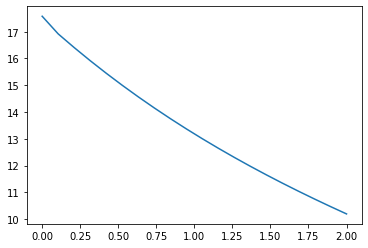

In [204]:
plt.plot(y_grid_new, ems[25])

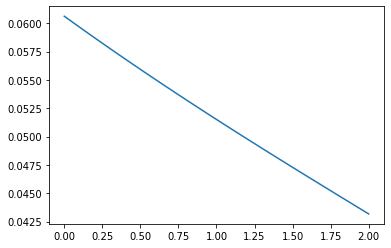

In [212]:
plt.plot(y_grid_new, phi[25])

In [206]:
dmgParams = (gamma_1, gamma_2, gamma2pList, gamma_bar, np.array([.5,.5]))
modelParams = (delta, eta, mu2, sigma2, rho, v_n)
phi,ems = false_transient(
    z_mat, y_mat, dmgParams, modelParams,
    bound_cond=terminal_condition[:,-1], bounded=True,
)

Episode: 1	 lhs error: 0.188770142678	 rhs error: 0.002231885113
Episode: 2	 lhs error: 0.032190264773	 rhs error: 1.842690340939
Episode: 3	 lhs error: 0.015025961249	 rhs error: 2.169851351439
Episode: 4	 lhs error: 0.028438000807	 rhs error: 2.323431413571
Episode: 5	 lhs error: 0.011793052608	 rhs error: 2.610513482672
Episode: 6	 lhs error: 0.016047346295	 rhs error: 2.492982307518
Episode: 7	 lhs error: 0.013499290769	 rhs error: 2.343937909902
Episode: 8	 lhs error: 0.009883514646	 rhs error: 2.208238534753
Episode: 9	 lhs error: 0.016147642661	 rhs error: 2.108839480278
Episode: 10	 lhs error: 0.001465694302	 rhs error: 1.946565305557
Episode: 11	 lhs error: 0.000948287125	 rhs error: 1.931833134854
Episode: 12	 lhs error: 0.000929512523	 rhs error: 1.923480887999
Episode: 13	 lhs error: 0.000912324707	 rhs error: 1.917904914926
Episode: 14	 lhs error: 0.000896429186	 rhs error: 1.913915158206
Episode: 15	 lhs error: 0.000881600265	 rhs error: 1.910963906261
Episode: 16	 lhs er

Episode: 126	 lhs error: 0.000272862219	 rhs error: 1.912760753984
Episode: 127	 lhs error: 0.000269979385	 rhs error: 1.912731697032
Episode: 128	 lhs error: 0.000267143470	 rhs error: 1.912683781717
Episode: 129	 lhs error: 0.000264274892	 rhs error: 1.912618375903
Episode: 130	 lhs error: 0.000261489059	 rhs error: 1.912612794617
Episode: 131	 lhs error: 0.000258710237	 rhs error: 1.912558536940
Episode: 132	 lhs error: 0.000255974386	 rhs error: 1.912521777068
Episode: 133	 lhs error: 0.000253249715	 rhs error: 1.912469896939
Episode: 134	 lhs error: 0.000250545293	 rhs error: 1.912450892228
Episode: 135	 lhs error: 0.000247863215	 rhs error: 1.912415435569
Episode: 136	 lhs error: 0.000245235767	 rhs error: 1.912382973240
Episode: 137	 lhs error: 0.000242604158	 rhs error: 1.912349785752
Episode: 138	 lhs error: 0.000240017692	 rhs error: 1.912318495107
Episode: 139	 lhs error: 0.000237472830	 rhs error: 1.912285812903
Episode: 140	 lhs error: 0.000234908159	 rhs error: 1.91226524

Episode: 252	 lhs error: 0.000064546884	 rhs error: 1.911407341967
Episode: 253	 lhs error: 0.000063725744	 rhs error: 1.911425776563
Episode: 254	 lhs error: 0.000062926063	 rhs error: 1.911409599682
Episode: 255	 lhs error: 0.000062134509	 rhs error: 1.911411430767
Episode: 256	 lhs error: 0.000061352159	 rhs error: 1.911405150481
Episode: 257	 lhs error: 0.000060577798	 rhs error: 1.911402291847
Episode: 258	 lhs error: 0.000059813084	 rhs error: 1.911403518010
Episode: 259	 lhs error: 0.000059067675	 rhs error: 1.911407153730
Episode: 260	 lhs error: 0.000058308373	 rhs error: 1.911424345097
Episode: 261	 lhs error: 0.000057563088	 rhs error: 1.911425892545
Episode: 262	 lhs error: 0.000056828333	 rhs error: 1.911402125911
Episode: 263	 lhs error: 0.000056102901	 rhs error: 1.911401705943
Episode: 264	 lhs error: 0.000055384714	 rhs error: 1.911400219792
Episode: 265	 lhs error: 0.000054674924	 rhs error: 1.911404333890
Episode: 266	 lhs error: 0.000053970983	 rhs error: 1.91140900

Episode: 378	 lhs error: 0.000010399693	 rhs error: 1.911383450022
Episode: 379	 lhs error: 0.000010226005	 rhs error: 1.911387530023
Episode: 380	 lhs error: 0.000010056128	 rhs error: 1.911391577367
Episode: 381	 lhs error: 0.000009887441	 rhs error: 1.911378761289
Episode: 382	 lhs error: 0.000009722413	 rhs error: 1.911385025719
Episode: 383	 lhs error: 0.000009562134	 rhs error: 1.911377971699
Episode: 384	 lhs error: 0.000009406823	 rhs error: 1.911391200417
Episode: 385	 lhs error: 0.000009242740	 rhs error: 1.911405045127
Episode: 386	 lhs error: 0.000009084090	 rhs error: 1.911379767828
Episode: 387	 lhs error: 0.000008931114	 rhs error: 1.911378271205
Episode: 388	 lhs error: 0.000008796413	 rhs error: 1.911389432373
Episode: 389	 lhs error: 0.000008640147	 rhs error: 1.911397995716
Episode: 390	 lhs error: 0.000008487476	 rhs error: 1.911393066839
Episode: 391	 lhs error: 0.000008342388	 rhs error: 1.911393233817
Episode: 392	 lhs error: 0.000008203060	 rhs error: 1.91138946

Episode: 502	 lhs error: 0.000002724625	 rhs error: 1.911385834497
Episode: 503	 lhs error: 0.000000955880	 rhs error: 1.911375894305
Episode: 504	 lhs error: 0.000000931632	 rhs error: 1.911383486320
Episode: 505	 lhs error: 0.000000915222	 rhs error: 1.911382701616
Episode: 506	 lhs error: 0.000000893574	 rhs error: 1.911385002960
Episode: 507	 lhs error: 0.000001414527	 rhs error: 1.911387209388
Episode: 508	 lhs error: 0.000000856754	 rhs error: 1.911388322815
Episode: 509	 lhs error: 0.000000836430	 rhs error: 1.911388555724
Episode: 510	 lhs error: 0.000001079061	 rhs error: 1.911386767231
Episode: 511	 lhs error: 0.000000800460	 rhs error: 1.911390431303
Episode: 512	 lhs error: 0.000001395759	 rhs error: 1.911388925172
Episode: 513	 lhs error: 0.000003083067	 rhs error: 1.911378218253
Episode: 514	 lhs error: 0.000001641695	 rhs error: 1.911396723205
Episode: 515	 lhs error: 0.000001400943	 rhs error: 1.911373358283
Episode: 516	 lhs error: 0.000001955556	 rhs error: 1.91138924

Episode: 625	 lhs error: 0.000000475876	 rhs error: 1.911379803601
Episode: 626	 lhs error: 0.000000154245	 rhs error: 1.911382998120
Episode: 627	 lhs error: 0.000000876027	 rhs error: 1.911381528202
Episode: 628	 lhs error: 0.000002200256	 rhs error: 1.911380331997
Episode: 629	 lhs error: 0.000000754966	 rhs error: 1.911387194665
Episode: 630	 lhs error: 0.000000600055	 rhs error: 1.911388198850
Episode: 631	 lhs error: 0.000000294955	 rhs error: 1.911380416093
Episode: 632	 lhs error: 0.000001550288	 rhs error: 1.911381622393
Episode: 633	 lhs error: 0.000002742856	 rhs error: 1.911388749648
Episode: 634	 lhs error: 0.000001802113	 rhs error: 1.911373979068
Episode: 635	 lhs error: 0.000000544081	 rhs error: 1.911392988647
Episode: 636	 lhs error: 0.000001563248	 rhs error: 1.911389308442
Episode: 637	 lhs error: 0.000000819271	 rhs error: 1.911374440426
Episode: 638	 lhs error: 0.000001379311	 rhs error: 1.911381241994
Episode: 639	 lhs error: 0.000002177877	 rhs error: 1.91138941

Episode: 748	 lhs error: 0.000001579080	 rhs error: 1.911380821975
Episode: 749	 lhs error: 0.000001425637	 rhs error: 1.911395537497
Episode: 750	 lhs error: 0.000001974672	 rhs error: 1.911382117320
Episode: 751	 lhs error: 0.000000346396	 rhs error: 1.911391753543
Episode: 752	 lhs error: 0.000002456678	 rhs error: 1.911390076940
Episode: 753	 lhs error: 0.000000876367	 rhs error: 1.911397150514
Episode: 754	 lhs error: 0.000001385668	 rhs error: 1.911388240272
Episode: 755	 lhs error: 0.000000653065	 rhs error: 1.911377851016
Episode: 756	 lhs error: 0.000000731122	 rhs error: 1.911383006158
Episode: 757	 lhs error: 0.000000700930	 rhs error: 1.911392014352
Episode: 758	 lhs error: 0.000000722334	 rhs error: 1.911384068957
Episode: 759	 lhs error: 0.000001820650	 rhs error: 1.911380305868
Episode: 760	 lhs error: 0.000001031674	 rhs error: 1.911389536622
Episode: 761	 lhs error: 0.000001208011	 rhs error: 1.911385258909
Episode: 762	 lhs error: 0.000001118834	 rhs error: 1.91137642

Episode: 872	 lhs error: 0.000001852453	 rhs error: 1.911387666304
Episode: 873	 lhs error: 0.000000929702	 rhs error: 1.911375925520
Episode: 874	 lhs error: 0.000001168811	 rhs error: 1.911384390545
Episode: 875	 lhs error: 0.000001294077	 rhs error: 1.911376446234
Episode: 876	 lhs error: 0.000000615695	 rhs error: 1.911390159501
Episode: 877	 lhs error: 0.000000436088	 rhs error: 1.911383849403
Episode: 878	 lhs error: 0.000001304884	 rhs error: 1.911388354859
Episode: 879	 lhs error: 0.000001082921	 rhs error: 1.911387787210
Episode: 880	 lhs error: 0.000000573133	 rhs error: 1.911374136894
Episode: 881	 lhs error: 0.000001836508	 rhs error: 1.911382714169
Episode: 882	 lhs error: 0.000001600380	 rhs error: 1.911385139455
Episode: 883	 lhs error: 0.000001801090	 rhs error: 1.911390467806
Episode: 884	 lhs error: 0.000001177616	 rhs error: 1.911376857241
Episode: 885	 lhs error: 0.000002196198	 rhs error: 1.911377129199
Episode: 886	 lhs error: 0.000000780751	 rhs error: 1.91138487

KeyboardInterrupt: 